In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [2]:
data_dir = os.getcwd() + '/oxml-carinoma-classification'
os.chdir(data_dir)

In [3]:
files = os.listdir()
files = [file for file in files if '.csv' not in file]

# Pipeline extracting aggregated features from single sample: 
minimum, maximum, mean and standard deviation of circularity, area, eccentricity, perimeter + total number of cells and area density  

Still to do: 
- remove thresholding artifacts (studd that is not really a cell)
- make this into a pipeline that can work on both training and test images
    - need something that can produce a pandas dataframe from the features, appending one after the other
    - need a flag for plots - so that I can completely remove all plots when running this on a bunch of images
- train a classifier (RF or XGB) on 2/3 of the images (about 40) and test on 1/3 (about 20-22) of the images

In [4]:
# Import usual libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import modules from skimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.filters import threshold_multiotsu
from skimage.draw import ellipse
from skimage.measure import regionprops, regionprops_table
from skimage.transform import rotate
# Import ndimage from scipy
from scipy import ndimage
# Import imutils and math as well
import imutils
import math

def get_features_image(file, plot = False): 
    # The input image.
    image = cv2.imread(file)
    # convert to grayscale and invert
    image = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Denoising via Gaussian Blur
    blur = cv2.GaussianBlur(image,(3, 3),0)

    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    thresholds = threshold_multiotsu(blur, classes = 4)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(blur, bins=thresholds)
    
    if plot == True:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

        # Plotting the original image.
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Original')
        ax[0].axis('off')

        # Plotting the histogram and the two thresholds obtained from
        # multi-Otsu.
        ax[1].hist(image.ravel(), bins=255)
        ax[1].set_title('Histogram')
        for thresh in thresholds:
            ax[1].axvline(thresh, color='r')

        # Plotting the Multi Otsu result.
        ax[2].imshow(regions, cmap='jet')
        ax[2].set_title('Multi-Otsu result')
        ax[2].axis('off')

        plt.subplots_adjust()

        plt.show()

    # Extract regions corresponding to cells
    cells = np.array([i if i == 3 else 0 for i in list(regions.reshape(-1))], dtype = np.uint8).reshape(image.shape[0], image.shape[1])


    # Watershed thresholded image
    # compute the exact Euclidean distance from every binary
    # pixel to the nearest zero pixel, then find peaks in this
    # distance map
    D = ndimage.distance_transform_edt(cells)
    localMax = peak_local_max(D, indices=False, min_distance=10, labels=cells)
    #plt.subplots(1, 3)
    #plt.subplot(131)
    #plt.imshow(image, cmap = 'gray')
    #plt.subplot(132)
    #plt.imshow(D, cmap = 'jet')
    #plt.subplot(133)
    #plt.imshow(localMax, cmap = 'jet')
    #plt.show()

    #plt.imshow(image + 500*localMax, cmap = 'gray')
    #plt.show()
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=cells)
    if plot == True:
        plt.imshow(labels)
        plt.show()


    # define function to get circularity out of region
    get_circularity = lambda region: (4 * math.pi * region.area) / (region.perimeter ** 2)

    features = {'circularity' : [], 
               'area' : [], 
               'eccentricity' : [], 
               'perimeter' : [], 
               'centroid' : []}
    # loop over the unique labels returned by the Watershed
    # algorithm
    for label in np.unique(labels):
        # if the label is zero, background = ignore
        if label == 0:
            continue
        # otherwise, create binary mask for individual region/object/hopefully cell
        mask = np.zeros(image.shape, dtype="uint8")
        mask[labels == label] = 255
        # get circularity of object
        circularity = [get_circularity(region) for region in regionprops(mask)]
        # get other built-in properties - estimates for size and shape
        props = regionprops_table(mask, properties=('centroid', 'area', 'eccentricity', 'perimeter'))
        features['circularity'].append(circularity[0])
        features['area'].append(props['area'][0])
        features['eccentricity'].append(props['eccentricity'][0])
        features['perimeter'].append(props['perimeter'][0])
        features['centroid'].append([props['centroid-0'][0], props['centroid-1'][0]])
    

    df = pd.DataFrame.from_dict(features)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()
    num_cells = len(df)
    #print(num_cells)
    
    def get_distances(centroids): 
        distances = []
        def get_euclidean_dist(x1, y1, x2, y2): 
            return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        
        for i in range(len(centroids)): 
            x1, y1 = centroids[i]
            for j in range(i+1, len(centroids)): 
                x2, y2 = centroids[j]
                distances.append(get_euclidean_dist(x1, y1, x2, y2))
                        
        return np.min(distances), np.max(distances), np.mean(distances), np.std(distances)

    min_circularity = df['circularity'].min()
    max_circularity = df['circularity'].max()
    mean_circularity = df['circularity'].mean()
    std_circularity = df['circularity'].std()

    min_eccentricity = df['eccentricity'].min()
    max_eccentricity = df['eccentricity'].max()
    mean_eccentricity = df['eccentricity'].mean()
    std_eccentricity = df['eccentricity'].std()

    min_area = df['area'].min()
    max_area = df['area'].max()
    mean_area = df['area'].mean()
    std_area = df['area'].std()

    min_perimeter = df['perimeter'].min()
    max_perimeter = df['perimeter'].max()
    mean_perimeter = df['perimeter'].mean()
    std_perimeter = df['perimeter'].std()
    
    min_dist, max_dist, mean_dist, std_dist = get_distances(df['centroid'].values)

    # Build cumulative mask
    mask = np.zeros(image.shape, dtype="uint8")
    for label in np.unique(labels):
        # if the label is zero, background = ignore
        if label == 0:
            continue
        # otherwise, create binary mask for individual region/object/hopefully cell
        mask[labels == label] = 1
    density = sum(sum(mask))/(image.shape[0]*image.shape[1]) # find area density of cells in FOV of sample

    aggregated_features = [min_circularity, max_circularity, mean_circularity, std_circularity,
                min_eccentricity, max_eccentricity, mean_eccentricity, std_eccentricity,
                min_area, max_area, mean_area, std_area, 
                min_perimeter, max_perimeter, mean_perimeter, std_perimeter, 
                min_dist, max_dist, mean_dist, std_dist, 
                num_cells, density]
    return aggregated_features

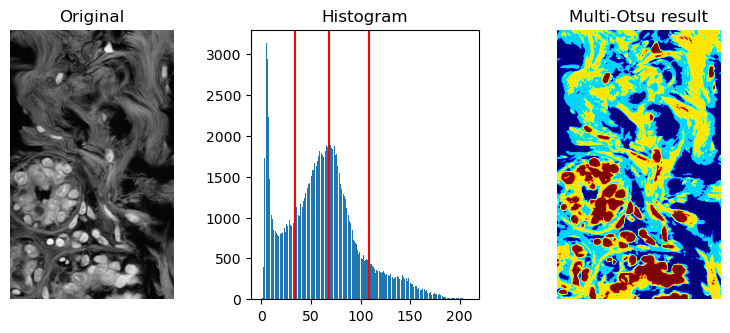

/var/folders/hm/4tf8_bk116sghbv11mksbw540000gn/T/ipykernel_1516/1906471036.py:67: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=10, labels=cells)


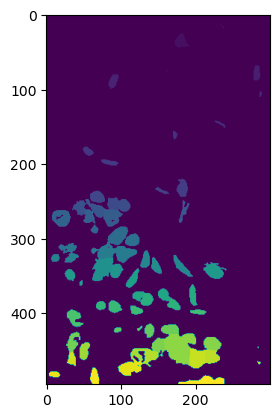

/var/folders/hm/4tf8_bk116sghbv11mksbw540000gn/T/ipykernel_1516/1906471036.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  get_circularity = lambda region: (4 * math.pi * region.area) / (region.perimeter ** 2)


[0.2675306413117234,
 3.2340725067158833,
 0.7846693447270058,
 0.3666258525070664,
 0.2222940639621022,
 0.9866791617225998,
 0.7311675150743462,
 0.18856744097319025,
 3,
 1268,
 226.18840579710144,
 184.10724778543357,
 3.414213562373095,
 167.15432893255073,
 60.75418885369581,
 30.05801675435263,
 7.6497809380465736,
 517.69154180534,
 169.90836170807782,
 102.49375838956588,
 69,
 0.10490591397849462]

In [5]:
get_features_image(files[0], plot = True)

# Get labelled data

In [55]:
import pandas as pd
import re

# Read labels CSV
labels = pd.read_csv('labels.csv')
# Get indices of labelled images from 'id' field
labelled_data_idx = list(labels['id'].values)
# List comprehension to fetch only the files with a numeric ID appearing in the labelled_data_idx
labelled_files = [file for file in files if int(re.findall('[0-9]+', file)[0]) in labelled_data_idx]
test_files = [file for file in files if int(re.findall('[0-9]+', file)[0]) not in labelled_data_idx]
test_idx = [int(re.findall('[0-9]+', file)[0]) for file in test_files]

<Axes: >

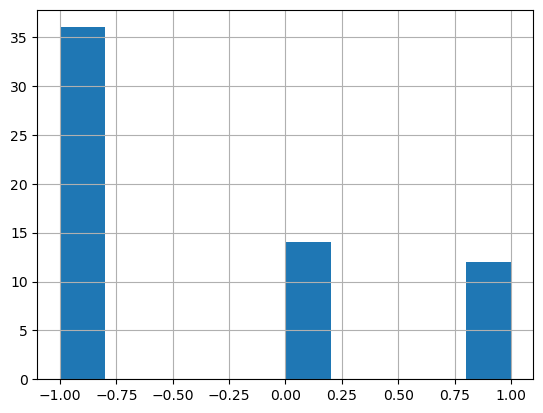

In [56]:
labels['malignant'].hist()

# Shifting labels from -1, 0, 1 to 0, 1, 2

In [57]:
Y = labels['malignant'].replace({-1 : 0, 0: 1, 1: 2})

<Axes: >

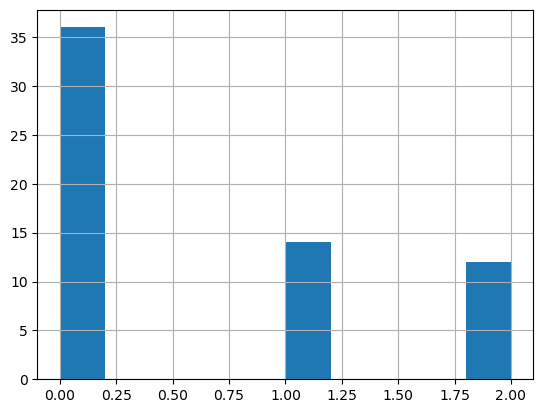

In [58]:
Y.hist()

In [59]:
X = pd.DataFrame(columns=['min_circ','max_circ','mean_circ','std_circ',
                         'min_ecc', 'max_ecc', 'mean_ecc', 'std_ecc', 
                         'min_area', 'max_area', 'mean_area', 'std_area', 
                         'min_per', 'max_per', 'mean_per', 'std_per', 
                         'min_dist', 'max_dist', 'mean_dist', 'std_dist',
                         'num_cells', 'density'])

import warnings
warnings.filterwarnings("ignore")

for file in labelled_files: 
    features = get_features_image(file)
    features_df = pd.DataFrame([features], columns=['min_circ','max_circ','mean_circ','std_circ',
                         'min_ecc', 'max_ecc', 'mean_ecc', 'std_ecc', 
                         'min_area', 'max_area', 'mean_area', 'std_area', 
                         'min_per', 'max_per', 'mean_per', 'std_per', 
                         'min_dist', 'max_dist', 'mean_dist', 'std_dist',
                         'num_cells', 'density'], dtype = np.float64)
    X = pd.concat([X, features_df], axis = 0)

In [60]:
X = X.reset_index().drop(columns = 'index')

In [61]:
X

,min_circ,max_circ,mean_circ,std_circ,min_ecc,max_ecc,mean_ecc,std_ecc,min_area,max_area,...,min_per,max_per,mean_per,std_per,min_dist,max_dist,mean_dist,std_dist,num_cells,density
0,0.267531,3.234073,0.784669,0.366626,0.222294,0.986679,0.731168,0.188567,3.0,1268.0,...,3.414214,167.154329,60.754189,30.058017,7.649781,517.691542,169.908362,102.493758,69.0,0.104906
1,0.280576,37.699112,1.246531,4.412437,0.305559,1.000000,0.757579,0.140101,3.0,762.0,...,1.000000,159.953319,68.673359,33.331716,10.000000,538.718594,208.181247,108.117979,140.0,0.207806
2,0.290148,2.579664,0.816481,0.340274,0.255553,0.995655,0.709441,0.176527,4.0,904.0,...,4.414214,150.403066,62.844616,33.012123,13.513122,486.321922,202.771802,120.964920,66.0,0.102870
3,0.137764,3.141593,0.614765,0.499048,0.000000,0.992497,0.794281,0.165479,4.0,1406.0,...,4.000000,252.415260,79.168042,57.149922,8.823255,589.246241,218.065353,106.086200,203.0,0.236512
4,0.153227,4.887008,0.719014,0.530939,0.000000,0.975661,0.762845,0.152486,3.0,1220.0,...,3.207107,201.444697,68.879844,40.410919,9.905958,917.365871,339.309722,187.637175,265.0,0.172224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.237940,12.566371,1.035575,1.367403,0.000000,1.000000,0.801387,0.143589,3.0,667.0,...,2.000000,153.130988,44.488915,26.237602,9.908224,854.393661,318.334893,171.011903,290.0,0.092873
58,0.270682,1.437366,0.795649,0.282326,0.395050,0.981939,0.789622,0.163624,12.0,785.0,...,10.242641,181.681241,58.631454,41.838478,13.342632,468.804616,196.170682,103.542770,40.0,0.058588
59,0.294737,37.699112,1.692832,5.031689,0.476055,1.000000,0.828727,0.150428,3.0,1743.0,...,1.000000,243.438600,50.605529,48.008308,10.085549,498.219446,219.133635,113.195658,59.0,0.061210
60,0.094731,2.317325,0.585895,0.374789,0.000000,0.991690,0.836492,0.146526,5.0,877.0,...,5.207107,322.078210,66.299054,48.426638,7.049473,605.045944,231.285105,112.453838,275.0,0.216450


# Try training a simple classifier

In [62]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer

In [63]:
xgbC = XGBClassifier() # default parameters
# using cross validation to avoid splitting stuff to test set
cv_scores = cross_val_score(xgbC, X, Y, cv = 5, scoring=make_scorer(f1_score, average = 'micro'))

In [64]:
cv_scores

array([0.53846154, 0.30769231, 0.58333333, 0.5       , 0.33333333])

In [65]:
np.mean(cv_scores)

0.45256410256410257

In [66]:
# re-training on whole training dataset
xgbC.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Get predictions on test dataset and save as 'predictions.csv'

In [68]:
# getting features for test dataset to predict labels
X_test = pd.DataFrame(columns=['min_circ','max_circ','mean_circ','std_circ',
                         'min_ecc', 'max_ecc', 'mean_ecc', 'std_ecc', 
                         'min_area', 'max_area', 'mean_area', 'std_area', 
                         'min_per', 'max_per', 'mean_per', 'std_per', 
                         'min_dist', 'max_dist', 'mean_dist', 'std_dist',
                         'num_cells', 'density'])

import warnings
warnings.filterwarnings("ignore")

for index, file in enumerate(test_files): 
    assert str(test_idx[index]) in file
    features = get_features_image(file)
    features_df = pd.DataFrame([features], columns=['min_circ','max_circ','mean_circ','std_circ',
                         'min_ecc', 'max_ecc', 'mean_ecc', 'std_ecc', 
                         'min_area', 'max_area', 'mean_area', 'std_area', 
                         'min_per', 'max_per', 'mean_per', 'std_per', 
                         'min_dist', 'max_dist', 'mean_dist', 'std_dist',
                         'num_cells', 'density'], dtype = np.float64)
    X_test = pd.concat([X_test, features_df], axis = 0)

In [69]:
X_test

,min_circ,max_circ,mean_circ,std_circ,min_ecc,max_ecc,mean_ecc,std_ecc,min_area,max_area,...,min_per,max_per,mean_per,std_per,min_dist,max_dist,mean_dist,std_dist,num_cells,density
0,0.283707,37.699112,1.351352,3.948468,0.000000,1.000000,0.820009,0.159111,3.0,754.0,...,1.000000,159.580736,46.454932,31.503823,8.814702,882.458985,324.085409,188.920463,176.0,0.081322
0,0.199618,37.699112,1.373330,4.406447,0.000000,1.000000,0.772820,0.155138,3.0,676.0,...,1.000000,168.953319,51.842552,28.832796,8.034839,869.030816,301.194880,160.693200,359.0,0.155282
0,0.200845,3.234073,0.739401,0.357903,0.393900,0.984246,0.767905,0.127259,3.0,951.0,...,3.414214,175.509668,67.844558,38.338422,14.452307,538.475688,191.844492,96.328501,101.0,0.139589
0,0.299829,12.566371,0.974987,1.114263,0.000000,1.000000,0.768563,0.190365,3.0,714.0,...,2.000000,145.610173,49.882657,31.278968,11.582191,544.658834,221.420282,107.691478,141.0,0.134528
0,0.278804,3.141593,0.834232,0.355995,0.000000,0.974129,0.713005,0.178375,4.0,741.0,...,4.000000,144.361436,57.371693,26.083509,12.932503,663.590637,219.108188,130.612284,81.0,0.066101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.335649,12.566371,0.893314,1.065023,0.231020,1.000000,0.796450,0.126229,3.0,887.0,...,2.000000,167.130988,52.723399,24.819889,10.373511,496.563937,174.266716,87.629285,133.0,0.167696
0,0.261621,37.699112,1.175418,3.748822,0.000000,1.000000,0.762660,0.200732,3.0,543.0,...,1.000000,143.882251,54.478842,27.477127,13.748254,570.583084,207.484604,115.634047,98.0,0.083399
0,0.219740,37.699112,1.790212,5.929494,0.394240,1.000000,0.785629,0.137631,3.0,4365.0,...,1.000000,353.634560,63.180072,57.191213,9.603313,463.744880,172.028157,85.770226,77.0,0.188039
0,0.129930,2.353627,0.762000,0.488910,0.203653,0.990493,0.771010,0.149529,4.0,3035.0,...,4.621320,346.847763,81.251648,77.562860,9.284350,496.634166,200.484095,96.062026,103.0,0.243204


In [70]:
X_test = X_test.reset_index().drop(columns = 'index')

In [71]:
y_pred_test = xgbC.predict(X_test)

In [72]:
y_pred_test = pd.DataFrame(y_pred_test).replace({0 : -1, 
                                   1: 0, 
                                   2: 1})

In [73]:
y_pred_test = y_pred_test.rename(columns = {0 : 'malignant'})

In [74]:
y_pred_test = y_pred_test.reset_index().drop(columns = 'index')


In [75]:
y_pred_test['id'] = test_idx

In [86]:
y_pred_test = y_pred_test[['id', 'malignant']].sort_values(by = 'id')

In [88]:
y_pred_test.to_csv('predictions_sorted.csv', index = False)

In [80]:
len(y_pred_test)

124